이미지 생성 모델로 사용되는 GAN에 조건을 부여해 내가 원하는 유형의 이미지를 생성해 낼 수 있도록 해보자.

## 1. 조건 없는 생성모델(Unconditional Generative Model), GAN

GAN과 같은 unconditional generative model의 단점
- 노이즈를 계속 입력으로 넣어보며 원하는 종류의 이미지를 바로 생성해 내지 못함 (제어하기 어려움)

바로바로 생성해 내기 위해서
- GAN에 원하는 이미지를 만들기 위한 특정 조건을 줘보자!

## 2. 조건 있는 생성모델(Conditional Generative Model), cGAN

내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소해, 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법

#### 🐥 GAN의 목적 함수
GAN: Generator 및 Discriminator라 불리는 두 신경망이 minimax game을 통해 서로 경쟁하며 발전하려 하는데, Generator은 아래 식을 `최소화`, Discriminator은 아래 식을 `최대화`하려 학습한다.

<br/>

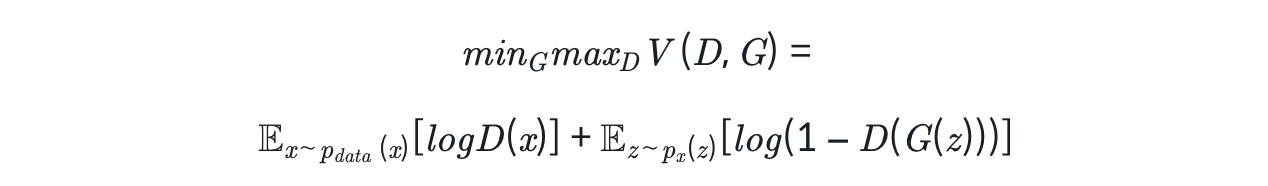

<br/>

z: 임의의 노이즈, $D$: Discriminator, $G$: Generator

<br/>

**D의 입장** <br/>
실제 이미지를 1, 가짜 이미지를 0으로 두었을 때 $D$는 이 식을 최대화 해야 하므로, $D(x)$는 1이, $D(G(z))$는 0이 되도록 해야 한다. <br/>
즉, 진짜 데이터($x$)를 진짜로, 가짜 데이터($G(z)$)를 가짜로 정확히 예측하도록 학습한다.

<br/>

**G의 입장** <br/>
$G$는 위 식을 최소화 해야 하기 때문에 $D$와 반대로 $D(G(z))$가 1이 되도록 한다. <br/>
즉, $G$는 $z$를 입력받아 생성한 데이터 $G(z)$를 $D$가 진짜 데이터라고 예측할 만큼 진짜 같은 가짜 데이터를 만들도록 학습한다.

#### 🐥 cGAN의 목적 함수

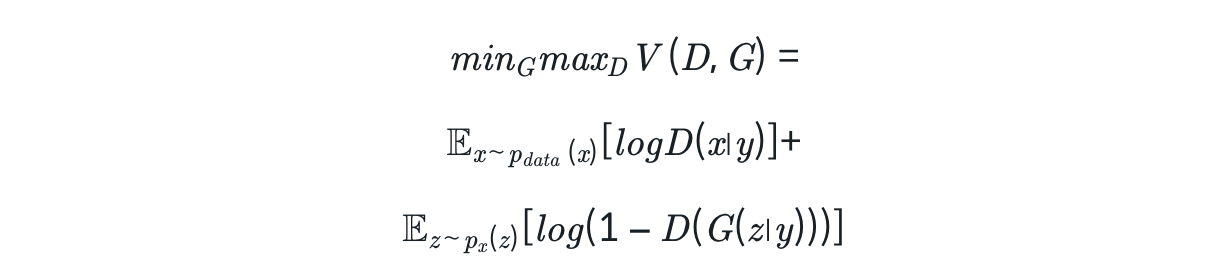

<br/>

-> $D(x)$와 $G(z)$가 각각 $D(x|y), G(x|z)$으로 바뀌었다.

즉, $G$와 $D$의 입력에 특정 조건을 나타내는 정보인 $y$를 같이 입력한다.
- 여기서 $y$는 어떠한 정보여도 상관 없고, MNIST 데이터셋을 학습시키는 경우 $y$는 0~9의 label 정보가 된다.
- Generator가 어떤 노이즈 $z$를 입력받았을 때, 특정 조건 $y$가 함께 입력되므로 **$y$가 임의 노이즈 입력인 $z$의 가이드**라 할 수 있다.

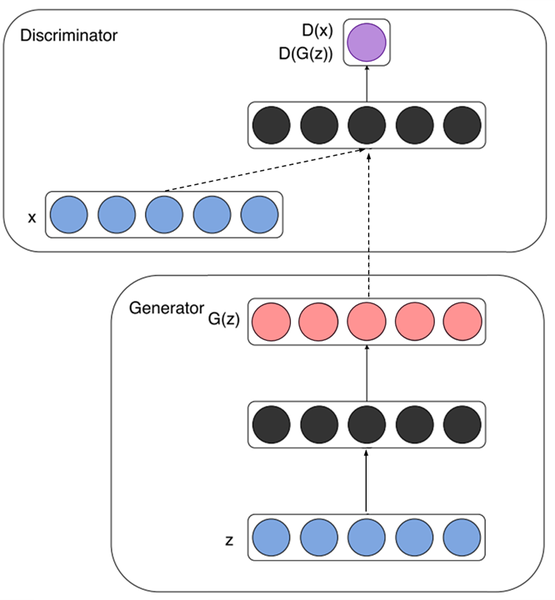

<br/>

**Generator**: 노이즈 $z$(파란색)가 입력되고 특정 representation(껌정색)으로 변환된 후 가짜 데이터 $G(z)$ (빨간색)를 생성함

**Discriminator**: 실제 데이터 $x$와 Generator가 생성한 가짜 데이터 $G(z)$를 입력 받아 $D(x)$ 및 $D(G(z))$ (보라색)을 계산해 진짜와 가짜 식별함

<br/>

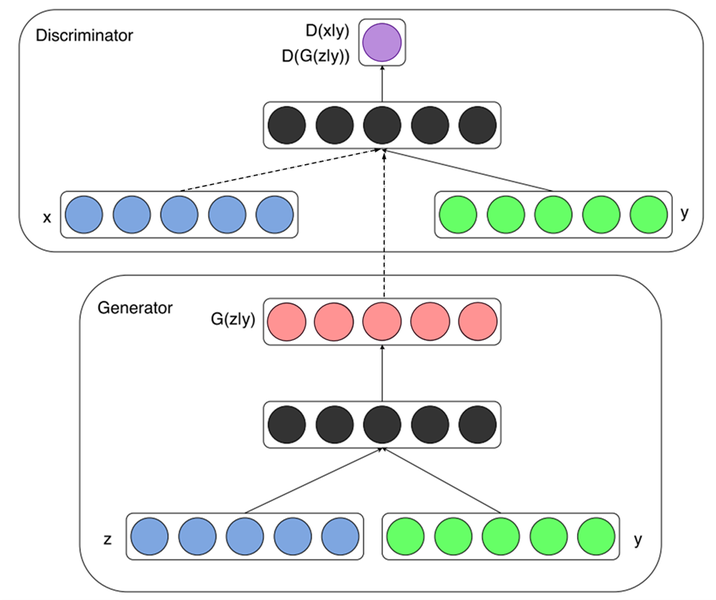

**Generator**: 노이즈 $z$(파란색)와 추가 정보 $y$(녹색)을 함께 입력 받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되어 가짜 데이터 $G(z|y)$를 생성한다.
- $y$는 레이블 정보이며, 일반적으로 one-not 벡터를 입력으로 넣음 <br/>

**Discriminator**: 실제 데이터 x와 Generator가 생성한 가짜 데이터 $G(z|y)$, 마찬가지로 $y$정보가 각각 함께 입력되어 진자와 각자를 식별한다. 실제 데이터 $x$와 $y$는 알맞은 한쌍('7'이라 쓰인 이미지의 경우 레이블도 7)을 이뤄야 하며, 마찬가지로 Generator에 입력된 $y$와 Discriminator에 입력된 $y$는 동일한 레입르을 나타내야 한다.

## 3. 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기

MNIST 데이터셋을 이용해 간단하게 GAN과 cGAN을 구현하고 실험해보자.
- 임의 노이즈 및 레이블 정보로 숫자 이미지 생성하는 Generator
- [TF2-GAN](https://github.com/thisisiron/TF2-GAN) 참조

### 데이터 준비하기

In [1]:
# $ pip install tensorflow-dataset

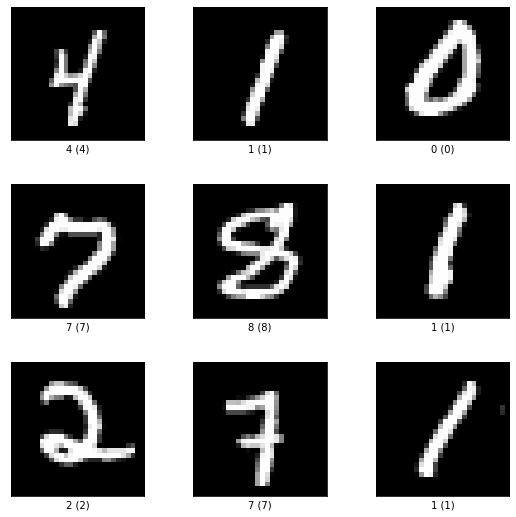

In [2]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

> `show_examples` 를 통해 여러 개의 숫자 이미지와 그에 맞는 레이블이 출력되었다.

> 이미지 픽셀 값을 -1 ~ 1 범위로 변경하고, 레이블 정보를 one-hot encoding하였다.
> - GAN과 cGAN 각각을 실험하기 위해 label 정보 사용 유무에 따라 `gan_preprocessing()`과 `cgan_preprocessing()` 두 가지 함수를 구성

In [3]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10) # cgan에서는 label 정보 사용
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

Label : tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


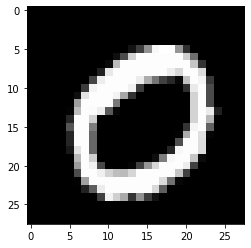

In [4]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

> 이미지로 `9`가 출력되었고, 라벨로는 `[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]`, 즉 마찬가지로 `9`가 출력되었다.

### GAN Generator 구성하기

Tensorflow2의 **Subclassing** 방법 이용하기
- tensorflow.keras.Model을 상속받아 클래스를 만들며, `__init()__` 메서드 안에서 레이어 구성을 정의, 구성된 레이얼르 `call()` 메서들르 사용해 forward propagation을 진행
- Pytorch의 모델 구성 방법과 유사함!

In [5]:
# GAN의 Generator
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise) # noise: z
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out) # G(z)

> - 4개의 `fully-connected 레이어` 중 1개를 제외하고 모두 ReLU 활성화 함수 사용
> - `call()` 메서드는 노이즈를 입력으로 받아 `__init__()`에서 정의된 레이어들을 순서대로 통과함
> - Generator은 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 `layers.Reshape()`을 이용해 (28, 28, 1) 크기로 변환됨

### cGAN Generator 구성하기

In [6]:
# cGAN의 Generator
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise) # 노이즈
        label = self.dense_y(label) # 레이블 정보
        out = self.combined_dense(tf.concat([noise, label], axis=-1)) # combine
        out = self.final_dense(out)
        return self.reshape(out) # G(z|y)

## 4. 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기

### GAN Discriminator 구성하기
- 실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해보기

In [7]:
# GAN의 Discriminator

class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

> - `__init()__`에 `blocks`라는 리스트를 하나 만들고, for 루프를 이용해 필요한 레이어들을 쌓았다.
> - 각각의 fully connected layer를 매번 정의하지 않아도 돼서 많은 레이어가 필요할 때 편리하다.
> - `Discriminator`의 입력은 Generator가 생성한 (28, 28, 1) 크기의 이미지이며, 이를 fully-connected layer로 학습하기 위해 먼저 `layers.Flatten()`이 적용되어 레이어들이 쌓여있는 `blocks`에 대해 for문을 통해 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과시킨다.
> - 마지막 fully-connected layer를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력된다.

### cGAN Discriminator 구성하기
`Maxout`: 두 레이어 사이를 연결할 때, 여러 개의 fully-connected layer를 통과시켜 그 중 가장 큰 값을 가져온다.

<br/>

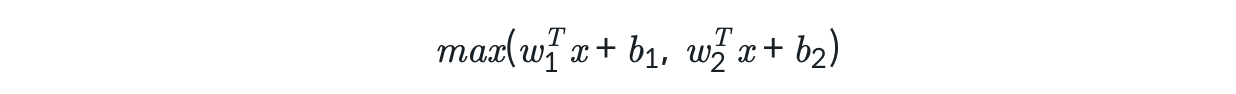

<br/>

: 2개의 fully-connected layer를 사용했을 때의 식

<br/>

만약 1차원 fully-connected layer라고 가정하면 아래과 같이 2개의 직선으로 이루어진 activation nfunction으로 나타낼 수 있을텐데,

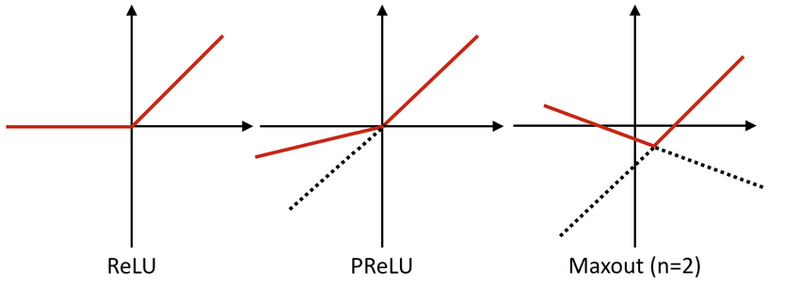

<br/>

사용하는 fully-connected layer의 수가 늘어난다면 곡선 형태의 activation function이 될 수 있어 다차원 공간에 곡면을 나타낼 수 있을 것이다.

<br/>

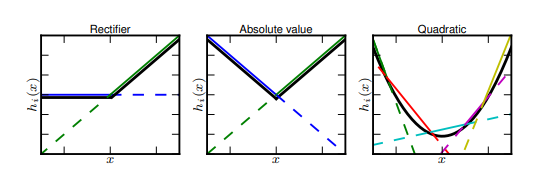

In [8]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

> `units`: 차원 수를 가진 fully-connected 레이어를 `pieces`개만큼 만들고 그 중 최댓값을 출력.

ex) `Maxout` 레이어가 `units=100`, `piecs=10`인 경우
- 입력으로부터 100차원의 representation을 10개 만들고, 10개 중 최댓값을 가져와 최종 1개의 100차원 representation이 출력된다.

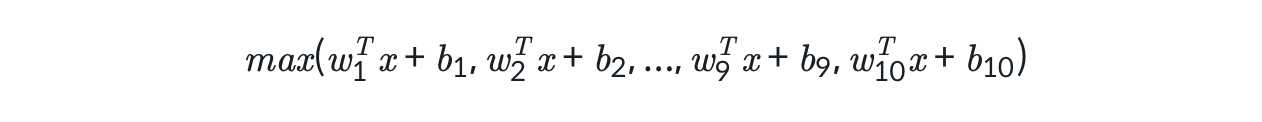

> 위에서 정의한 `Maxout` 레이어를 3번만 사용하면 쉽게 cGAN의 Discriminator를 구성할 수 있다.

In [9]:
# cGAN의 Discriminator
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        # 이해가 잘 안간다.
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image) # 실제 데이터
        label = self.label_block(label) # 레이블 정보
        x = layers.Concatenate()([image, label]) # 합침
        x = self.combine_block(x)
        return self.dense(x)

## 5. 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기

생성한 Generator와 Discriminator을 이용해 MNIST를 학습하고 각 모델로 직접 손글씨 생성해보기
- GAN, cGAN 모델 학습에 공통적으로 필요한 loss function과 optimizer 정의
- 진짜 및 가짜를 구분하기 위해 `Binary Cross Entropy`를 사용하고, `Adam optimizer`를 이용해 학습하자.

In [10]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

# tf.ones_like(): 모든 원소의 값이 1인 텐서 생성
def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)

> - generator은 fake_output이 1에 가까울수록 좋음 (loss값이 작다.)
> - discriminator은 real_output은 1에, fake_output은 0에 가까울수록 좋음 (loss값이 작다.)

### GAN으로 MNIST 학습하기
- 입력으로 사용되는 noise는 100차원으로 설정

In [11]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    
    return gene_loss, disc_loss

> - 텐서플로우에선 `GradientTape`를 사용해 주어진 입력에 대한 연산의 미분 값을 자동으로 계산
> - ❓ **질문**: 이전 DCGAN 노드를 살펴보니 tf.GradientTape()에서 gen_tape, disc_tape을 따로 불러왔는데, 그러지 않아도 괜찮은지!

In [12]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        # 100번의 반복마다 각 loss를 출력함
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.200953960418701, D:0.13575094938278198
[1/10 EPOCHS, 200 ITER] G:2.6153297424316406, D:0.08996470272541046
[1/10 EPOCHS, 300 ITER] G:2.8065526485443115, D:0.14757362008094788
[1/10 EPOCHS, 400 ITER] G:2.6676478385925293, D:0.199571430683136
[2/10 EPOCHS, 100 ITER] G:2.6988630294799805, D:0.1703461855649948
[2/10 EPOCHS, 200 ITER] G:4.084251403808594, D:0.1447223573923111
[2/10 EPOCHS, 300 ITER] G:4.630274772644043, D:0.028528988361358643
[2/10 EPOCHS, 400 ITER] G:3.0162792205810547, D:0.12845443189144135
[3/10 EPOCHS, 100 ITER] G:4.570994853973389, D:0.043864842504262924
[3/10 EPOCHS, 200 ITER] G:3.6784133911132812, D:0.12314419448375702
[3/10 EPOCHS, 300 ITER] G:4.669730186462402, D:0.10812482982873917
[3/10 EPOCHS, 400 ITER] G:6.277997970581055, D:0.11522112786769867
[4/10 EPOCHS, 100 ITER] G:4.295368671417236, D:0.06201746687293053
[4/10 EPOCHS, 200 ITER] G:4.133821487426758, D:0.04617252200841904
[4/10 EPOCHS, 300 ITER] G:3.608859062194824, D:0.057981356

> 100차원 노이즈 10개를 입력해 10개의 숫자 손글씨 데이터를 생성하고 시각화 한다.

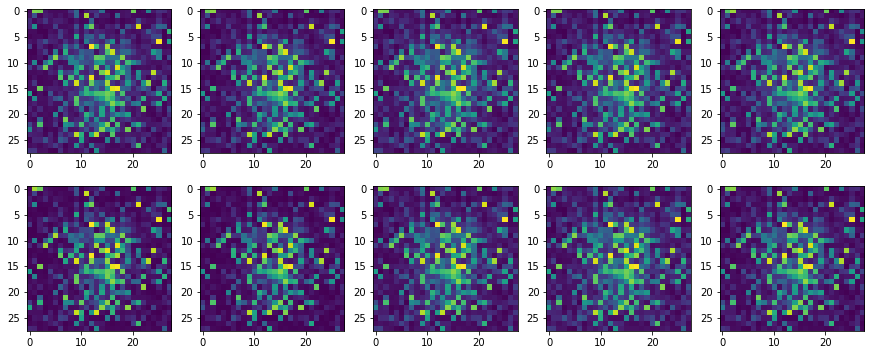

In [13]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

> 10 epoch의 학습만으로는 좋은 결과가 나올 수 없다.
> - 위 구현을 그대로 500 epoch 학습한 가중치가 준비되어 있으니 확인해보자.

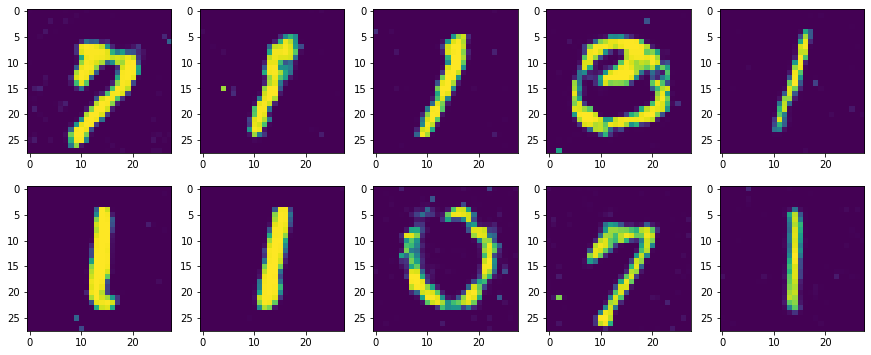

In [14]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15, 6))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(output[i-1])

> 내가 원하는 특정 숫자 하나를 출력하기 위해선 수많은 입력을 넣어야 할 것이다.
> - 이렇게 하기 위해 cGAN을 학습 시켜 보자.

### cGAN으로 MNIST 학습하기

여기서도 GAN처럼 약간의 학습으론 제대로 된 생성 겨로가를 얻을 수 없을 것이기 때문에 1 epoch만 학습시켜보기

In [15]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:6.277711868286133, D:0.003291334956884384
[1/1 EPOCHS, 199 ITER] G:6.4079389572143555, D:0.005090239457786083
[1/1 EPOCHS, 299 ITER] G:6.185834884643555, D:0.004616668913513422
[1/1 EPOCHS, 399 ITER] G:5.854898929595947, D:0.02967132441699505


> 위 코드로 500 epoch 학습한 가중치 이용하기
> - `number` 변수에 0~9 사이의 숫자 중 원하는 숫자를 입력하고, 코드를 실행해보자.

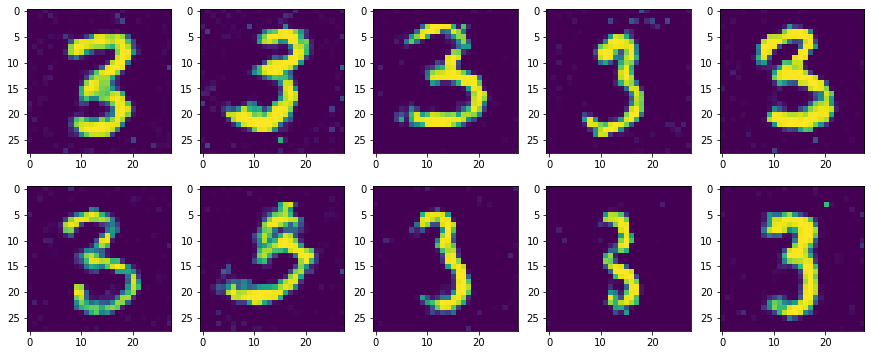

In [16]:
number = 3  # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

> -> `number`에 입력한 숫자에 해당하는 손글씨가 시각화 되었다.

## 6. GAN의 입력에 이미지를 넣는다면? Pix2Pix

### Pix2Pix
: 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아닌, **이미지를 입력으로 해 원하는 다른 형태의 이미지로 변환**할 수 있는 GAN 모델
- cGAN와 같이 클래스 레이블 등의 조건을 입력하는 게 아니라, 내가 원하는 이미지를 얻기 위해 이미지를 조건으로 주기
- **[Image-to-Image Translation](https://arxiv.org/pdf/1611.07004.pdf)**


한 이미지의 픽셀에서 다른 이미지의 픽셀로 (pixel to pixel) 변환한다는 뜻에서 Pix2Pix 라는 이름으로 불린다.
- 이 구조는 최근 활발히 연구되는 GAN 기반의 Image-to-Image Translation 작업에서 가장 기초가 되는 연구

노이즈와 레이블 정보를 함께 입력한 cGAN은 **fully-connected** 레이어를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 **convolution** 레이어를 활용함

### Pix2Pix (Generator)
Generator는 어떠한 이미지를 입력받아 변환된 이미지를 출력하기 위해 사용됨
- 입력된 이미지와 변환된 이미지의 크기는 동일해야 함

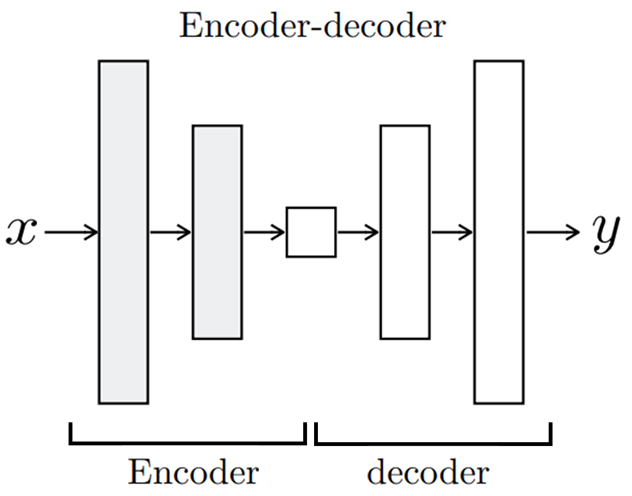

<br/>

- Encoder에서 입력 이미지($x$)를 받으면 단계적으로 down-sampling하며 입력 이미지의 중요한 representation을 학습한다.
- Decoder에서는 반대로 다시 이미지를 up-sampling하여 입력 이미지와 동일한 크기의 변환된 이미지($y$)를 생성해냄
- 위 과정이 모두 convolution 레이어로 진행된다.
- Encoder의 최종 출력은 가운데 위치한 가장 작은 사각형이 `bottleneck`이라고도 불리는데, 입력 이미지($x$)의 가장 중요한 특징만을 담는다.
> 이 작은 특징이 변환된 이미지($y$)를 생성하는데 충분한 정보를 줄지?

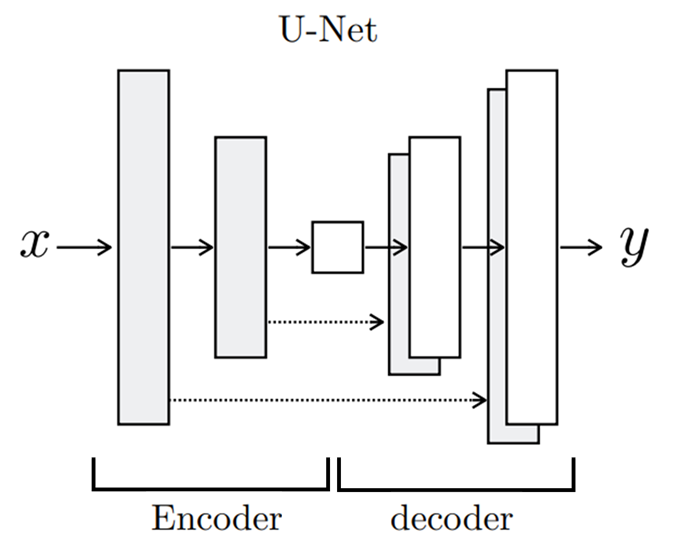

<br/>

위 논문에선 Generator 구조를 하나 더 제안하는데, 위 그림과 같은 **U-Net** 구조이다.
- 각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있음
- Decoder가 변환된 이미지를 더 잘 생성하도록 Encoder로부터 더 많은 추가 정보를 이용
- 아래와 같이 단순한 Encoder-Decoder 구조의 Generator보다 더 선명한 결과를 얻을 수 있음

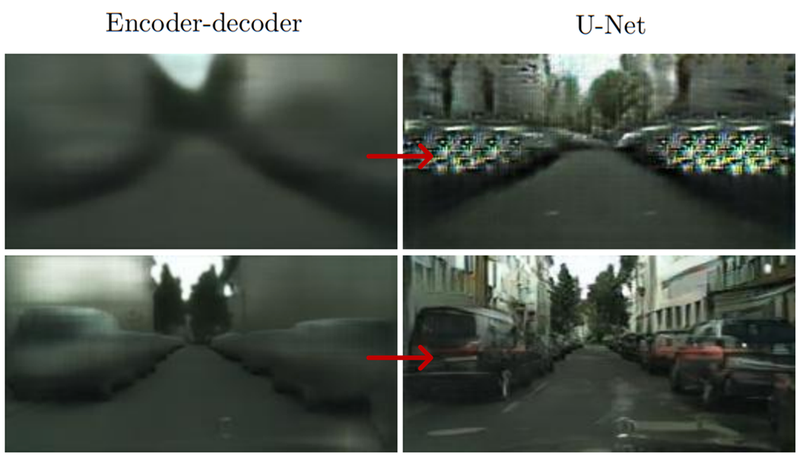

<br/>

- [U-Net 논문 리뷰](https://medium.com/@msmapark2/u-net-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-u-net-convolutional-networks-for-biomedical-image-segmentation-456d6901b28a)

### Pix2Pix (Loss Function)

"Generator만으로도 이미지 변환이 가능할까?"

출력된 이미지와 실제 이미지의 차이로 L2(MSE), L1(MAE) 같은 손실을 계산한 후 이를 역전파하여 네트워크를 학습시키면 됨.
- but, 이미지의 품질 차이가 있을 것

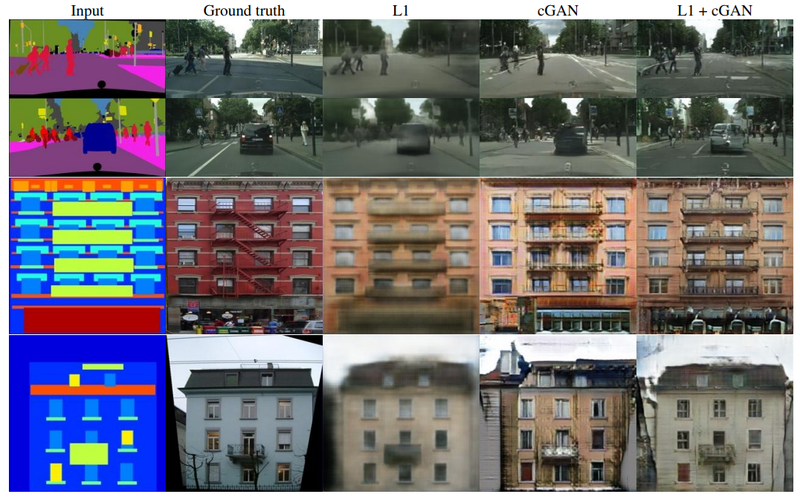

<br/>

- L1이나 L2 손실만을 사용해 학습을 하면 결과가 흐릿한 경우가 많다.
- Generator는 단순히 이미지의 평균적인 손실만을 줄이기 위해 파라미터를 학습하기 때문에 이런 현상은 불가피하다.

- 위 그림처럼 cGAN을 보면 Discriminator을 이용한 GAN 기반 학습 방법이 훨씬 더 세밀한 정보를 잘 표현한다는 것을 알 수 있을 것이다.
- Discriminator을 잘 속이려면 Generator가 (Ground truth라고 쓰여진 이미지와 같이) 진짜같은 이미지를 만들어야 하기 때문이다.
- 논문에서는 L1 손실 + GAN 손실을 사용하면 더 좋은 결과를 얻을 수 있다고 한다.

### Pix2Pix (Discriminator)

아래 그림은 DCGAN의 Discriminator이다.

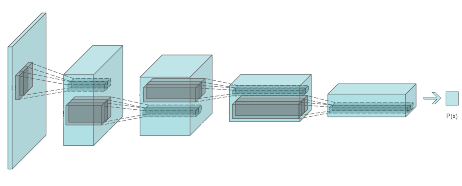

<br/>

DCGAN의 Discriminator는 생성된 가짜 이미지 or 진짜 이미지를 하나씩 입력받아 convolution 레이어를 통해 점점 크기를 줄여나가며, 최종적으로 하나의 이미지에 대해 하나의 확률 값을 출력한다.

<br/>

"하나의 이미지에 대해 하나의 확률 값만을 도출하는 것이 좋은 것일까?"

<br/>

라는 의문점으로, Pix2Pix는 조금 다른 방식의 Discriminator를 사용한다.

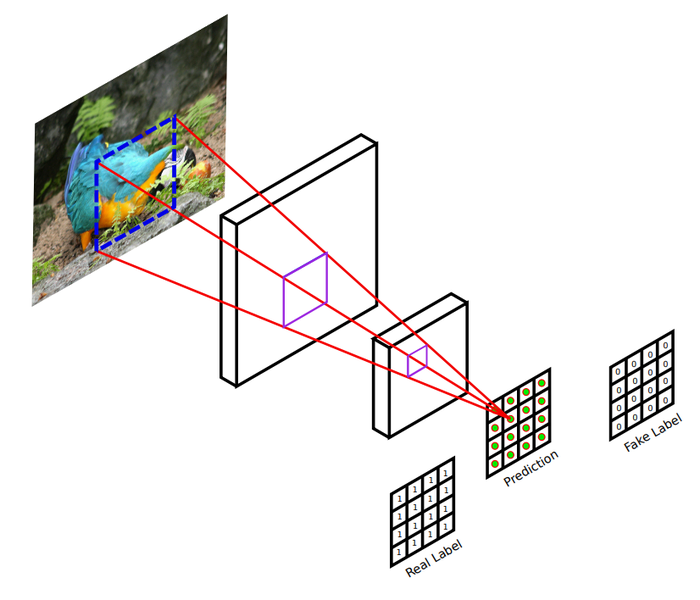

<br/>

위 그림을 보면, 하나의 이미지가 Discriminator의 입력으로 들어오면, convolution 레이어를 거쳐 확률 값을 나타내는 최종 결과를 생성하는데, 그 결과는 하나의 값이 아닌 여러 개의 값을 갖는다. (위 그림에서 Prediction은 16개의 값을 가짐) <br/>

위 그림에서 **파란색 점선**은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력 이미지의 **receptive field** 영역을 나타낸다. 전체 영역을 다 보는 것이 아닌 **일부 영역**(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출한다.

이런식으로 서로 다른 영역에 대해 진짜/가짜를 나타내는 여러 개의 확률 값을 계산하고, 그 값을 평균내 최종 Discriminator의 출력을 생성한다. 이러한 방버은 이미지의 일부 영역(patch)을 이용한다 하여 **PatchGAN**이라 불린다. <br/>
- 일반적으로 이미지에서 **거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문**에 특정 크기를 가진 **일부 영역에 대해 세부적으로 진짜/가짜를 판별**하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 한다.

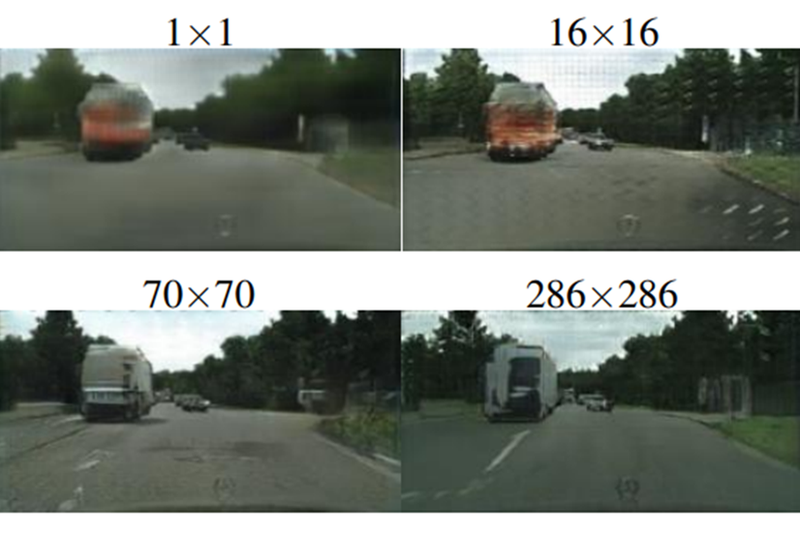

<br/>

위 그림은 (위위 그림의 파란색 점선 같은) 판별 영역을 다양한 크기로 실험한 결과인데, 마지막의 286x286 이미지는 DCGAN의 Discriminator와 같이 전체 이미지에 대해 하나의 확률 값을 출력했다. <br/>
70x70, 16x16, 1x1로 갈수록 더 작은 영역을 보고 각각의 확률 값을 출력한 것이기 때문에 Discriminator의 출력값의 개수가 더 많다. 너무 작은 patch를 사용하면 품질이 좋지 않고, 70x70 patch가 286x286보다 좀 더 사실적인 이미지를 생성하므로 PatchGAN의 사용이 성공적이라 볼 수 있을 것이다.

## 7. 난 스케치를 할 테니 넌 채색을 하거라 (1) 데이터 준비하기

pix2pix 모델을 직접 구현하고 실험할텐데, 사용할 데이터는 `Sketch2Pokemon`이라는 데이터셋이다.

- [Sketch2Pokemon](https://www.kaggle.com/norod78/sketch2pokemon) 
    - 위 데이터셋은 training set에 830개의 데이터가 있는데 256x256 크기의 이미지 쌍이 나란히 2개 붙어 512x256 크기의 이미지로 구성되어 있다.

In [17]:
import os

data_path = os.getenv('HOME') + '/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


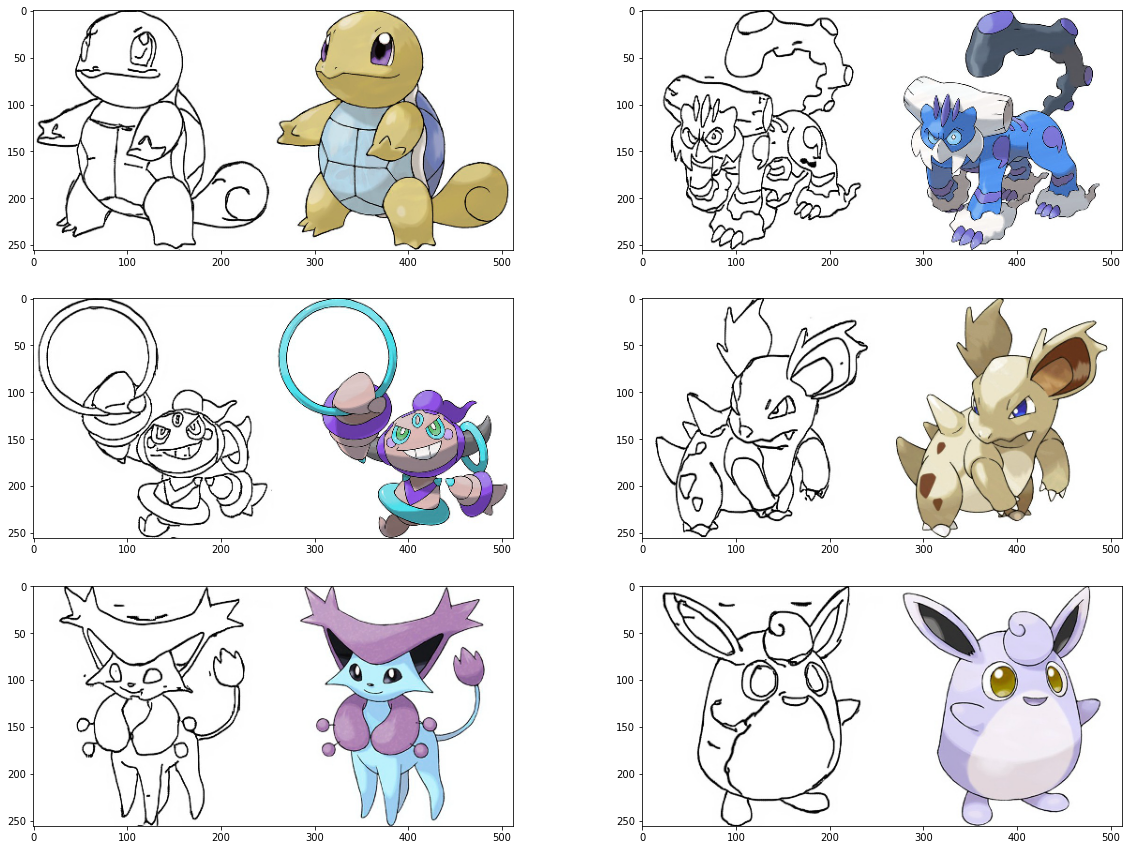

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

# training data에서 임의로 6장을 선택해 시각화
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR) # cv2.IMREAD_COLOR: 이미지를 컬러로 로드해 투명한 부분은 모두 무시
    plt.subplot(3, 2, i)
    plt.imshow(img)

In [19]:
f = data_path + os.listdir(data_path)[0] # 첫 번째 이미지
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


> 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할해 사용하면 되겠다.

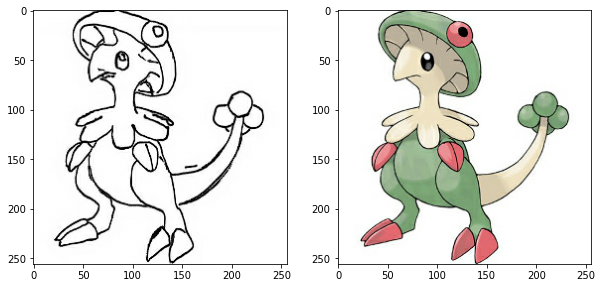

In [20]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1 # 정규화

def denormalize(x):
    x = (x+1) * 127.5 # 역정규화
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2 # 512 -> 256
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1); plt.imshow(denormalize(sketch))
plt.subplot(1, 2, 2); plt.imshow(denormalize(colored))

> 아래 코드는 denormalize(normalize())를 두 번 씌우지 않고 바로 이미지를 출력해보려고 수정한 load_img 함수
> - 아무 과정을 거치지 않으면 type이 `<class 'tensorflow.python.framework.ops.EagerTensor'>`이고,
> - `denormalize`까지 과정을 거쳐야 type이 `<class 'numpy.ndarray'>`이 된다.
>> 따라서 픽셀 값을 조정해주는 127.5 등의 과정은 생략하고, `.numpy()` 변환 후 `.astype(np.uint8)`로 int로 형변환을 해주었다.

In [21]:
# import tensorflow as tf

# def load_img(img_path):
#     img = tf.io.read_file(img_path)
#     img = tf.image.decode_image(img, 3)
    
#     w = tf.shape(img)[1] // 2
#     sketch = img[:, :w, :]
#     sketch = sketch.numpy().astype(np.uint8)
    
#     colored = img[:, w:, :] 
#     colored = colored.numpy().astype(np.uint8)
    
#     return sketch, colored

# f = data_path + os.listdir(data_path)[1]
# sketch, colored = load_img(f)

# # print(type(sketch), type(denormalize(normalize(sketch))))
# # print(sketch, denormalize(normalize(sketch)))

# plt.figure(figsize=(10, 7))
# plt.subplot(1, 2, 1); plt.imshow(sketch)
# plt.subplot(1, 2, 2); plt.imshow(colored)

> 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력해 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 목적이다.

> - 여기서 데이터는 약 800개뿐이므로 augmentation 기법을 활용해 데이터의 다양성을 높여보자.

In [22]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1) # 두 이미지가 채널 축으로 연결
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]]) # 30 픽셀의 pad width만큼 적용
    if tf.random.uniform(()) < .5: # 50%의 확률
        padded = tf.pad(stacked, _pad, "REFLECT") # reflection padding
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) # constant padding

    out = image.random_crop(padded, size=[256, 256, 6]) # (256, 256, 6) 크기를 가진 이미지를 임의로 잘라냄
    
    out = image.random_flip_left_right(out) # 50%의 확률로 좌우 반전
    out = image.random_flip_up_down(out) # 50%의 확률로 상하 반전
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree) # 50%의 확률로 회전
    
    return out[..., :3], out[..., 3:]

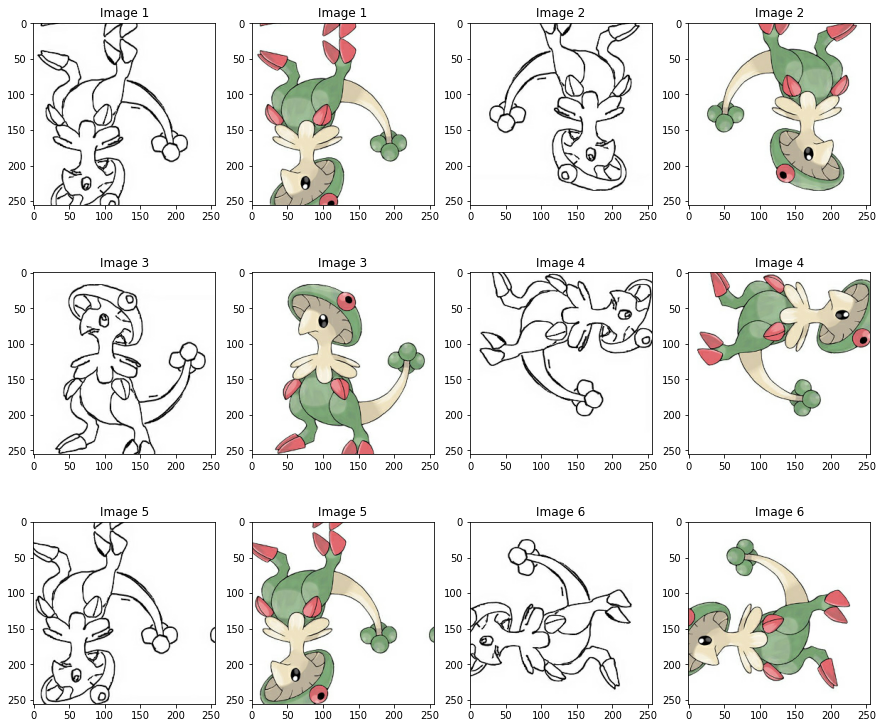

In [23]:
plt.figure(figsize=(15, 13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3, 4, i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3, 4, i+1);
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

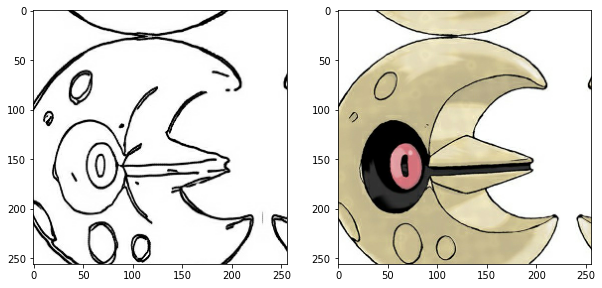

In [24]:
# 잘 적용 되었는지 하나의 이미지 시각화 해 확인해보기
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4) # 1배치 당 4개의 데이터

sample = train_images.take(1) # take(): 해당 배치를 몇 번 불러올 건지
sample = list(sample.as_numpy_iterator()) # as_numpy_iterator(): 데이터의 모든 요소를 numpy로 변환
sketch, colored = (sample[0][0] + 1)*127.5, (sample[0][1] + 1)*127.5 # 역정규화

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(sketch[0].astype(np.uint8)) # type 변환
plt.subplot(1, 2, 2); plt.imshow(colored[0].astype(np.uint8)) # type 변환

## 8. 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기

Pix2Pix 구조를 구현하기. 앞서 cGAN 구현과 같이 Tensorflow의 Subclassing 방법을 이용해 모델을 만들자.

### Generator의 구성요소 알아보기

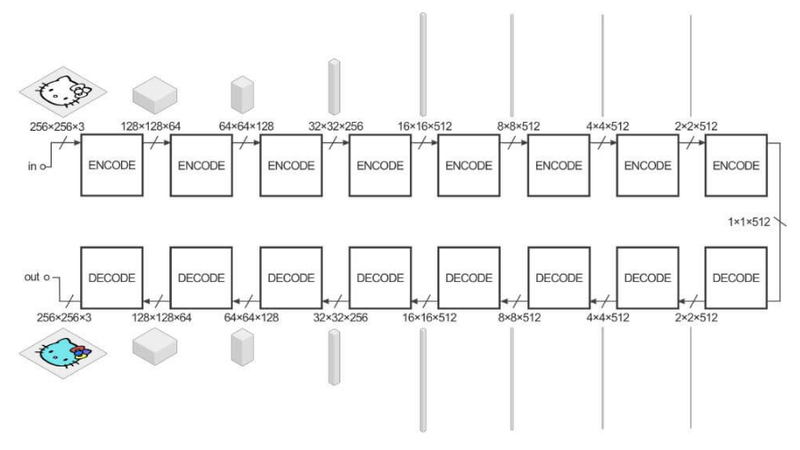

출처: https://neurohive.io/en/popular-networks/pix2pix-image-to-image-translation/

<br/>

위 그림에서 'in'의 입력부터 화살표를 쭉 따라가면 계산된 결과의 (width, height) 크기가 점점 절반으로 줄어들어 최종적으로 (1, 1)이 되며 채널 수는 512까지 늘어난다. <br/>
아랫줄 화살표를 따라가보면 (width, height)는 점점 두배로 늘어나 다시 (256, 256) 크기가 되고, 채널 수는 점점 줄어 들어 처음 입력과 같이 3채널이 된다.

### Generator 구현하기

`Convolution -> BatchNorm -> LeakyReLU`

In [25]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

> - `__init__()` 메서드에서 `n_filters`, `use_bn`를 설정해 사용할 필터의 개수와 BatchNorm 사용 여부를 결정할 수 있다.
> - Conv 레이어에서 필터의 크기(4) 및 stride(2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각 값을 지정했다.

In [26]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

> - 각 블록을 거쳐 사용할 필터의 수는 `filters` 리스트에 저장해두었고, `blocks`이라는 리스트에는 사용할 블록들을 정의해 넣어두고, `call()` 메서드에서 차례대로 블록들을 통과함
> - Encoder 첫 번째 블록에선 BatchNorm을 적용하지 않음
> - `get_summary()`: 레이어가 잘 구성되었는지 확인하는 욛오

In [27]:
# (256, 256, 3) 크기의 데이터 입력했을 때, 어떻게 출력되는지
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

> 블록 통과할수록 (width, height)는 크기가 1/2로 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1, 1, 512)로 알맞은 크기가 출력됨

In [29]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3: # 처음 3개의 블록에서만 Dropout 사용
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1, 1, 512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [30]:
# (1, 1, 512) 크기의 데이터가 입력되었을 때, 어떻게 출력되는지
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

> (width, height) 크기가 점점 늘어나 사용 필터의 수는 점점 줄어들어 최종 (256, 256, 3) 크기로 잘 출력됨

위 Encoder와 Decoder를 연결시키면 (256, 256, 3) 의 입력이 (1, 1, 512)로 변환된 뒤 다시 (256, 256, 3)으로 되어 스케치를 입력으로 채색된 이미지 출력을 얻을 수 있을 것이다.

> `tf.keras.Model`을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성해보자.

In [31]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## 9. 난 스케치를 할 테니 넌 채식을 하거라 (3) Generator 재구성하기

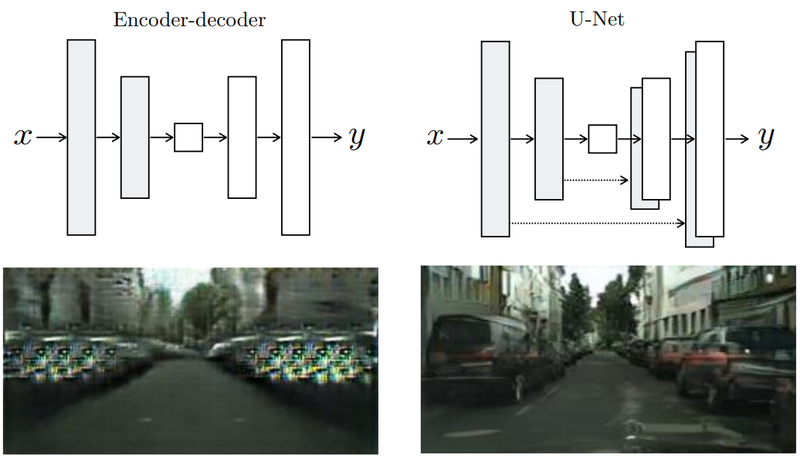

<br/>

이전 단계에서 구현한 Generator은 위 그림의 Encoder-Decoder 구조인데, 더 좋은 결과를 기대하기 위해 U-Net구조를 만들어보자.

In [33]:
# Encoder, Decoder에서 사용되는 기본적인 블록

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

#### U-Net Generator

> `__init__()` 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의한 뒤, `call()`에서 forward propagation을 함
> - 이전 구현에 없었던 skip connection이 `call()` 내부에서 어떻게 구현되었는지 잘 확인하기

In [34]:
# U-Net Generator 정의

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        # Encoder 및 Decoder 내부 연산 수행
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = [] # for 'skip connection'
        for block in self.encode_blocks:
            x = block(x)
            features.append(x) # Encoder에서 사용된 각 블록들의 출력 담음
        
        features = features[:-1] # 마지막 Encoder의 출력은 Decoder로 직접 입력되므로
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

> - `__init__()` 에서 정의된 `encode_blocks` 및 `decode_blocks`가 `call()` 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산 수행
> - 이 때, Encoder와 Decoder 사이의 skip connection을 위해 `features`라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담음
> - 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가며 다시 한 번 각각의 Decoder를 통과하는데, `features` 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됨

✔️ `features[::-1]`
- Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고,
- Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 두 번째 블록에 연결되는 ... 등의 대칭을 이룬다.

- features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해 features의 역순으로 연결한다.


✔️ `skip connection`은 가장 마지막 축(채널 축)을 기준으로 서로 연결됨

In [35]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

> 이전 Encoder-Decoder Generator 구조에서 학습할 파라미터 수는 약 4000만 개였는데, skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만개로 1500만개가 증가함

> - U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지며 학습해야 할 파라미터가 늘어났다. (필터의 수는 같음)

## 10. 난 스케치를 할 테니 넌 채색을 하거라 (4) Discriminator 구성하기

좀 더 사실적인 이미지를 생성하기 위해선 Generator 뿐만 아니라 Discriminator도 만들어 Pix2Pix 구조를 완성시켜 보자.


### Discriminator의 구성요소 알아보기
진짜 or 가짜 이미지 판별하기 위해 최종 출력에 sigmoid를 사용하는 것 제외하면 동일하다.

<br/>

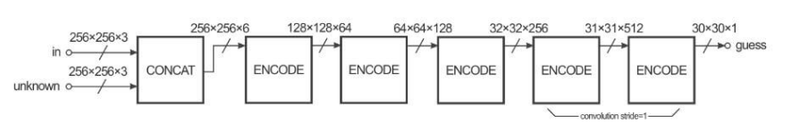

출처: https://neurohive.io/en/popular-networks/pix2pix-image-to-image-translation/


<br/>

Discriminator은 2개의 입력('in', 'unknown')을 받아 연결(concat)한 후, `ENCODE`라고 쓰인 5개의 블록을 통과한다. 이 중 마지막 블록은 1(채널)차원 출력을 위한 블록이다.

출력 이전의 `ENCODE` 블록을 보면 출력 크기가 32, 31, 30으로 1씩 감소하는데,
- 2 stride convolution에 패딩을 이용하면 (w, h)가 절반으로 감소하고
- 1 stride convolution에 패딩을 하지 않으면 (w, h)의 크기가 3씩 감소한다. (필터 크기가 4이므로)
- ✔️ 1씩 감소하려면 다른 방법 써야 할듯

위 예제에서 최종 출력 크기가 (30, 30, 1)이 된 이유는 앞서 Discriminator에서 70x70 PatchGAN을 사용했기 때문
- ❓ 최종 (30, 30) 출력에서 각 픽셀의 receptive field의 크기를 (70, 70)으로 맞춰주기 위해 Discriminator의 출력 크기를 (30, 30) 크기로 강제로 맞추는 과정이다.

### Discriminator 구현하기

In [36]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

`__init()__`에서
- 필터의 수(`n_filters`),
- 필터가 순회하는 간격(`stride`),
- 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(`custom_pad`),
- BatchNorm의 사용 여부(`use_bn`),
- 활성화 함수 사용 여부(`act`) 설정 가능

> 1. (128, 128, 32) 크기의 입력이 **`layers.ZeroPadding2D()`** 를 통과하면, width 및 height의 양쪽면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어남 -> `(130, 130, 32)`
> 2. 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height가 3씩 줄어듬. 이는 **`Outsize = (Insize + 2*PadSize - FilterSize) / Stride + 1`** 의 식으로 계산 가능 -> (127, 127, 64)
> 3. 이 외 다른 레이어(BatchNorm, LeakeyReLU)는 출력의 크기에 영향을 주지 않음

In [37]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


이런 식으로 (width, height) 크기를 1씩 감소시킬 수 있다.


Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30, 30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설정했다.

In [38]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256, 256, 3), y_shape=(256, 256, 3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

> `__init__()` 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼(주석 처리) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었다.
> - 첫 번째 블록은 단순 연결(`concat`)을 수행하며, Discriminator의 최종 출력은 `sigmoid` 활성화를 사용함

In [39]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

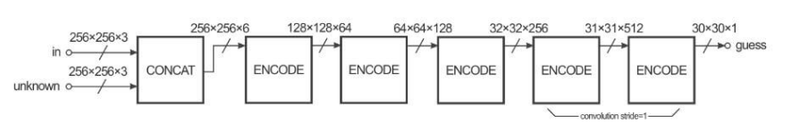

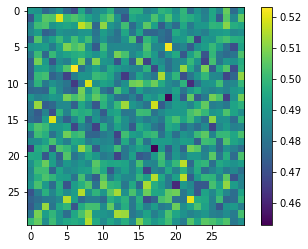

In [40]:
# 시험삼아 임의의 (256, 256, 3)의 입력을 넣어 나오는 (30, 30) 출력 시각화 하기
x = tf.random.normal([1, 256, 256, 3])
y = tf.random.uniform([1, 256, 256, 3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

> 위 (30, 30) 크기를 갖는 결과 이미지의 각 픽셀 값은 원래 입력의 (70, 70) 패치에 대한 분류 결과이다.
> - 전체의 입력의 크기가 (256, 256) 이므로, 각 (70, 70) 패치는 원래 입력상에서 많이 겹쳐있을 것이다. 각 픽셀의 결괏값은 `sigmoid` 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해 내는데 사용한다.

## 11. 난 스케치를 할 테니 넌 채색을 하거라 (5) 학습 및 테스트하기

구현된 Generator와 Discriminator를 학습시켜 보고, 스케치를 입력으로 채색된 이미지를 생성해 보기.

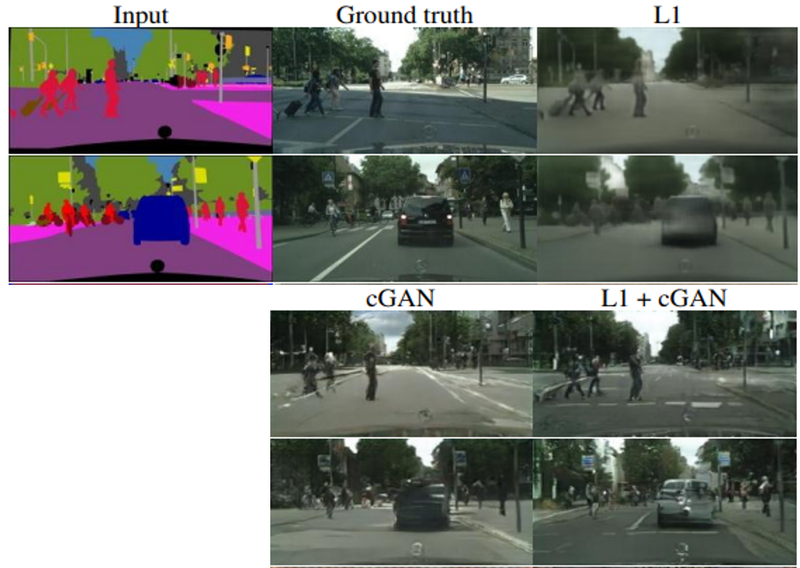

<br/>

논문에 따르면 GAN 손실 함수에 L1을 추가로 사용했을 때 실제에 가까운 이미지를 생성해 냈다.

In [41]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

#### Generator의 손실 함수 (`get_gene_loss`)
- **`fake_disc`**: Generator가 생성한 가짜 이미지를 Discriminator에 입력해 얻은 값
- 실제 이미지(1)와 비교하기 위해 `tf.ones_like()` 이용
- L1 손실을 계산하기 위해 생성한 가짜 이미지(**`fake_output`**)와 실제 이미지(**`real_output`**) 사이의 MAE(Mean Absolute Error)를 계산함


#### Discriminator의 손실 함수(`get_disc_loss`)
- **`fake_disc`, `real_disc`**: 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값
- Discriminator는 실제 이미지를 잘 구분해 내야 하므로 **`real_disc`**는 1로 채워진 벡터와 비교, **`fake_disc`**는 0으로 채워진 벡터와 비교

In [42]:
from tensorflow.keras import optimizers

# 논문과 동일하게 optimizer 설정하기
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [43]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    return gene_loss, l1_loss, disc_loss

> **`gene_total_loss`**: 최종 Generator 손실을 구할 때 L1 손실에 100을 곱하는데, 논문에서 Generator 손실을 아래와 같이 정의한다. 

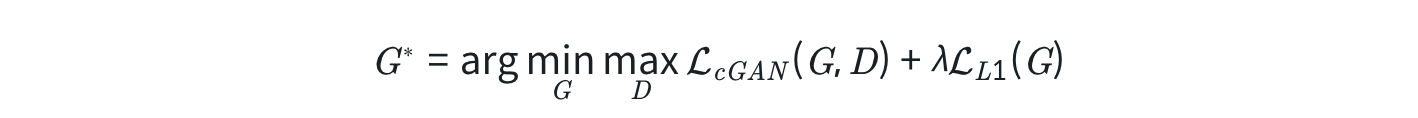

<br/>

λ는 학습 과정시 L1 손실을 얼마나 반영할 것인지를 나타내며, 100으로 사용했다.

In [44]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0569                     
L1_loss:0.5669                     
Discriminator_loss:1.0359

EPOCH[1] - STEP[20]                     
Generator_loss:0.9118                     
L1_loss:0.3512                     
Discriminator_loss:1.0359

EPOCH[1] - STEP[30]                     
Generator_loss:0.9508                     
L1_loss:0.3835                     
Discriminator_loss:1.3177

EPOCH[1] - STEP[40]                     
Generator_loss:0.9298                     
L1_loss:0.2451                     
Discriminator_loss:1.0301

EPOCH[1] - STEP[50]                     
Generator_loss:1.0741                     
L1_loss:0.3018                     
Discriminator_loss:0.8450

EPOCH[1] - STEP[60]                     
Generator_loss:1.8883                     
L1_loss:0.2848                     
Discriminator_loss:0.5889

EPOCH[1] - STEP[70]                     
Generator_loss:0.5526                     
L1_loss:0.2128                    

EPOCH[3] - STEP[170]                     
Generator_loss:0.4914                     
L1_loss:0.2299                     
Discriminator_loss:1.2625

EPOCH[3] - STEP[180]                     
Generator_loss:0.6812                     
L1_loss:0.2300                     
Discriminator_loss:1.9549

EPOCH[3] - STEP[190]                     
Generator_loss:2.5579                     
L1_loss:0.2808                     
Discriminator_loss:0.4020

EPOCH[3] - STEP[200]                     
Generator_loss:2.9546                     
L1_loss:0.2606                     
Discriminator_loss:0.3013

EPOCH[4] - STEP[10]                     
Generator_loss:1.4423                     
L1_loss:0.3180                     
Discriminator_loss:0.3959

EPOCH[4] - STEP[20]                     
Generator_loss:2.4195                     
L1_loss:0.2815                     
Discriminator_loss:0.7367

EPOCH[4] - STEP[30]                     
Generator_loss:2.6119                     
L1_loss:0.2367                

EPOCH[6] - STEP[130]                     
Generator_loss:1.0379                     
L1_loss:0.2367                     
Discriminator_loss:0.6658

EPOCH[6] - STEP[140]                     
Generator_loss:0.4977                     
L1_loss:0.2481                     
Discriminator_loss:1.1175

EPOCH[6] - STEP[150]                     
Generator_loss:2.0745                     
L1_loss:0.2893                     
Discriminator_loss:0.2310

EPOCH[6] - STEP[160]                     
Generator_loss:1.3788                     
L1_loss:0.2809                     
Discriminator_loss:0.4520

EPOCH[6] - STEP[170]                     
Generator_loss:2.2335                     
L1_loss:0.2780                     
Discriminator_loss:0.6882

EPOCH[6] - STEP[180]                     
Generator_loss:3.6306                     
L1_loss:0.2533                     
Discriminator_loss:0.5848

EPOCH[6] - STEP[190]                     
Generator_loss:1.5874                     
L1_loss:0.2145             

EPOCH[9] - STEP[90]                     
Generator_loss:3.2301                     
L1_loss:0.2479                     
Discriminator_loss:0.1201

EPOCH[9] - STEP[100]                     
Generator_loss:0.1809                     
L1_loss:0.2326                     
Discriminator_loss:1.9570

EPOCH[9] - STEP[110]                     
Generator_loss:2.1020                     
L1_loss:0.2242                     
Discriminator_loss:0.5002

EPOCH[9] - STEP[120]                     
Generator_loss:1.0922                     
L1_loss:0.2405                     
Discriminator_loss:0.7371

EPOCH[9] - STEP[130]                     
Generator_loss:2.7049                     
L1_loss:0.2279                     
Discriminator_loss:0.1834

EPOCH[9] - STEP[140]                     
Generator_loss:2.5325                     
L1_loss:0.2707                     
Discriminator_loss:0.1967

EPOCH[9] - STEP[150]                     
Generator_loss:1.6732                     
L1_loss:0.2933              

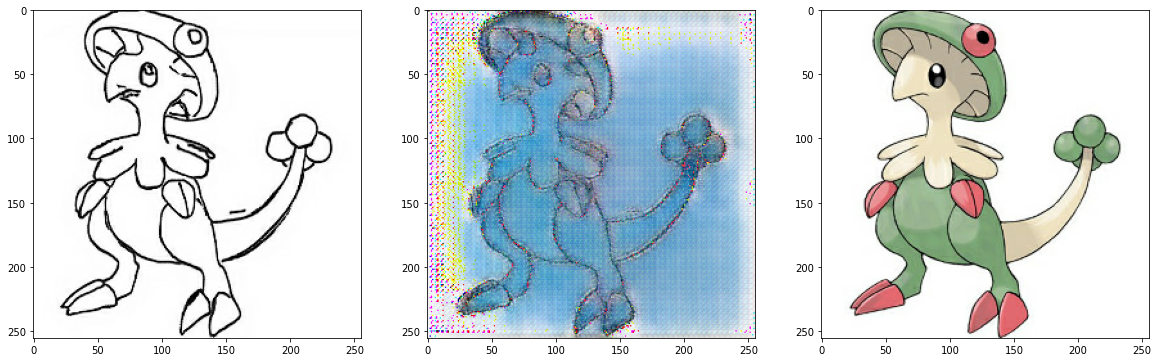

In [45]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

Pix2Pix로 128 epoch 학습 후 테스트 결과가 다음과 같다.
- 전체적인 색감 정도만 학습되며 세부적으로 제대로 채색되지 않는다.

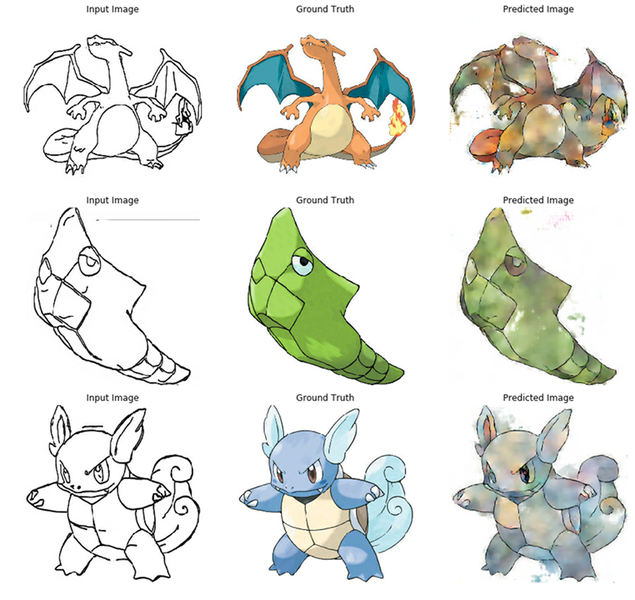

***

❓ GAN에서 내가 원하는 특정 숫자 이미지를 바로 출력할 수 없다는 부분이, cGAN에서는 가능하다는 말이 이해가 잘 안 간다.